## XGBOOST: 2.41

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# tools
import joblib
from typing import Tuple

# preprocess
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# model
import xgboost as xgb

### 컬럼설명
* Hour - 시간
* Minute - 분
* DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2)) : 태양광선이 대기를 통과하는 동안에 공기분자, 구름, 연무(aerosol) 입자 등으로 인하여 산란되어 도달되는 햇볕
* DNI - 직달일사량(Direct Normal Irradiance (W/m2)) : 태양으로부터 지표에 직접 도달하는 햇볕
* WS - 풍속(Wind Speed (m/s))
* RH - 상대습도(Relative Humidity (%))
* T - 기온(Temperature (Degree C))
* Target - 태양광 발전량 (kW)

In [2]:
def add_variable(df): # 파생변수 생성
    # 주차
    df['week'] = df['Day'] // 7

    # 전체 도달 에너지량 
    # (reference: https://www.researchgate.net/post/Why_does_the_solar_data_DNI_DHI_GHI_obtained_from_the_PVGIS_database_not_match_the_euqation)
    df['sum_energy'] = df['DHI'] + df['DNI']

    # 태양고도
    df['theta'] = 0
    condition_list = [
        (df['Hour'] == 6) | (df['Hour'] == 19),
        (df['Hour'] == 7) | (df['Hour'] == 18),
        (df['Hour'] == 8) | (df['Hour'] == 17),
        (df['Hour'] == 9) | (df['Hour'] == 16),
        (df['Hour'] == 10) | (df['Hour'] == 15),
        (df['Hour'] == 11) | (df['Hour'] == 14),
        (df['Hour'] == 12) | (df['Hour'] == 13)
    ]

    choice_list = [0,10,20,30,40,50,60]

    df['theta'] = np.select(condition_list, choice_list)

    # GHI
    df['GHI'] = df['DNI'] * np.cos(df['theta']) + df['DHI']
    
    return pd.DataFrame(df)

def preprocess(path, add_var): # 데이터 전처리
    df = pd.read_csv(path)
    df2 = df[:-96] # 2일씩 delay 시킨 데이터
    df2 = df2.drop('TARGET', axis = 1)
    df2['TARGET2'] = df['TARGET'].loc[96:].values
    if add_var == False:
        pass
    else:
        df2 = add_variable(df2)
    return pd.DataFrame(df2)

def data_split3(df, train): # train:valid:test 로 split
    X = df.drop('TARGET2', axis=1)
    y = df['TARGET2']
    if train == True:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)
        return X_train, X_valid, X_test, y_train, y_valid, y_test
    else:
        return X, y

In [3]:
df2 = preprocess('E:/solar_data/train/train.csv', add_var = True)
df2

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET2,week,sum_energy,theta,GHI
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,0,0,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0,0,0,0,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0,0,0,0,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0,0,0,0,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,1092,21,30,0,0,3.5,55.97,-1,0.0,156,0,0,0.0
52460,1092,22,0,0,0,3.9,54.23,-2,0.0,156,0,0,0.0
52461,1092,22,30,0,0,4.1,54.21,-2,0.0,156,0,0,0.0
52462,1092,23,0,0,0,4.3,56.46,-2,0.0,156,0,0,0.0


In [4]:
X_train, X_valid, X_test, y_train, y_valid, y_test = data_split3(df2, train = True)

# xgboost 학습을 위한 데이터
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_valid, label= y_valid)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [5]:
# customized quantile loss function
# reference: https://gist.github.com/Nikolay-Lysenko/06769d701c1d9c9acb9a66f2f9d7a6c7

def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    y = dtrain.get_label()
    errors = y - predt
    left_mask = errors >= 0
    right_mask = errors < 0
    return -quantile * left_mask + (1 - quantile) * right_mask

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    y = dtrain.get_label()
    return np.ones_like(predt)

def quantile_loss(predt: np.ndarray,
                dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [124]:
global quantile
result = pd.DataFrame([])
result['y_test'] = y_test.values

watch_list = [(dtrain,'train'), (dvalid,'valid')]
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    quantile = i
    print('quantile: ', quantile)
    model = xgb.train({'tree_method': 'gpu_hist'},
                      dtrain=dtrain,
                      obj = quantile_loss, num_boost_round = 100000,
                      evals= watch_list,
                      #evals_result = {'train': dtrain, 'eval':dvalid},
                     early_stopping_rounds = 50)
    joblib.dump(model, 'model_{}.pkl'.format(i))
    
    result['q_{}'.format(i)] = model.predict(dtest)
    print('check iteration #: ',i)
    print('-----------------------')

quantile:  0.1
[0]	train-rmse:31.50994	valid-rmse:28.76999
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1]	train-rmse:31.49297	valid-rmse:28.75414
[2]	train-rmse:31.47637	valid-rmse:28.73833
[3]	train-rmse:31.45985	valid-rmse:28.72264
[4]	train-rmse:31.44383	valid-rmse:28.70756
[5]	train-rmse:31.42718	valid-rmse:28.69185
[6]	train-rmse:31.41060	valid-rmse:28.67598
[7]	train-rmse:31.39403	valid-rmse:28.66054
[8]	train-rmse:31.37746	valid-rmse:28.64468
[9]	train-rmse:31.36099	valid-rmse:28.63003
[10]	train-rmse:31.34451	valid-rmse:28.61782
[11]	train-rmse:31.32807	valid-rmse:28.60560
[12]	train-rmse:31.31179	valid-rmse:28.59294
[13]	train-rmse:31.29550	valid-rmse:28.57740
[14]	train-rmse:31.27969	valid-rmse:28.56228
[15]	train-rmse:31.26331	valid-rmse:28.54640
[16]	train-rmse:31.24696	valid-rmse:28.53066
[17]	train-rmse:31.23063	valid-rmse:28.51764
[18]	train-rmse:31.21438	valid-rmse:28.5

KeyboardInterrupt: 

In [7]:
def compute_quantile_loss(y_true, y_pred, quantile):
    residual = y_true - y_pred
    loss = np.mean(np.maximum(quantile * residual, (quantile - 1) * residual))
    print('quantile {} - loss : {}'.format(quantile, loss))
    return loss

In [130]:
global quantile

final_result = pd.DataFrame([])

for i in range(0,81):
    path = 'E:/solar_data/test/' + str(i) + '.csv'
    df2 = preprocess(path, add_var = True)
    X, y = data_split3(df2, train = False)
    X1 = X.copy()
    X1['Minute'] = X1['Minute'].astype('str')
    X1['Minute'] = X1['Minute'].replace('0','00')
    dtest = xgb.DMatrix(data=X, label=y)

    result = pd.DataFrame([])
    result['y_true'] = y.values
    result['id'] = 0
    result['day'] = 0
    result['hour'] = 0
    
    for j,k in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        quantile = k
        loss = 0
        file_name = 'model_{}.pkl'.format(k) 
        model = joblib.load(file_name) 
        
        for h in range(len(X)):
            result['id'].loc[h] = '{}.csv_Day{}_{}h{}m'.format(i, X1['Day'].loc[h]+4,X1['Hour'].loc[h], X1['Minute'].loc[h])
            result['day'].loc[h] = X['Day'].loc[h]+4
            result['hour'].loc[h] = X['Hour'].loc[h]
    
        result['q_{}'.format(k)] = model.predict(dtest) * 1.3
        
        for h in range(len(X)):
            if (result['hour'].iloc[h] < 6) | (result['hour'].iloc[h] > 20):
                result['q_{}'.format(k)].iloc[h] = 0
            if result['q_{}'.format(k)].iloc[h] < 0:
                result['q_{}'.format(k)].iloc[h] = 0
                
        loss += compute_quantile_loss(result['y_true'], result.iloc[:,j+4], quantile = k)
        #print(result.columns)
    print('=================================================')
    final_result = pd.concat([final_result, result])

C:\Users\jasmi\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


quantile 0.1 - loss : 0.9289235144247957
quantile 0.2 - loss : 1.5990074027791485
quantile 0.3 - loss : 1.9482322897402182
quantile 0.4 - loss : 1.895385069137258
quantile 0.5 - loss : 1.7499938928349221
quantile 0.6 - loss : 1.5832561869783108
quantile 0.7 - loss : 1.474136778874762
quantile 0.8 - loss : 1.1043758291513974
quantile 0.9 - loss : 0.7421867373709875
quantile 0.1 - loss : 0.8293647864605965
quantile 0.2 - loss : 1.3416519054093847
quantile 0.3 - loss : 1.4267044449036042
quantile 0.4 - loss : 1.4054237561093317
quantile 0.5 - loss : 1.3345618438568592
quantile 0.6 - loss : 1.277464636917411
quantile 0.7 - loss : 1.1790075545871193
quantile 0.8 - loss : 0.823873221503225
quantile 0.9 - loss : 0.6003885622163561
quantile 0.1 - loss : 0.6386580602549744
quantile 0.2 - loss : 0.9910378270925058
quantile 0.3 - loss : 1.1787932295391907
quantile 0.4 - loss : 1.2771522446293198
quantile 0.5 - loss : 1.1123379654766843
quantile 0.6 - loss : 1.2877139196374285
quantile 0.7 - loss 

quantile 0.9 - loss : 0.698352291808575
quantile 0.1 - loss : 1.6275775832812258
quantile 0.2 - loss : 3.0879201431127337
quantile 0.3 - loss : 3.360245470993171
quantile 0.4 - loss : 3.246133443247062
quantile 0.5 - loss : 3.101928193976114
quantile 0.6 - loss : 2.6931957355172176
quantile 0.7 - loss : 2.661298565569898
quantile 0.8 - loss : 1.7654435442503318
quantile 0.9 - loss : 1.090059440002481
quantile 0.1 - loss : 1.7899946656061894
quantile 0.2 - loss : 3.5307721300596886
quantile 0.3 - loss : 3.8720654234021485
quantile 0.4 - loss : 4.54835162078729
quantile 0.5 - loss : 3.5490247690739434
quantile 0.6 - loss : 3.0685347922247366
quantile 0.7 - loss : 2.8626944557710403
quantile 0.8 - loss : 2.0091853193078655
quantile 0.9 - loss : 1.5605146165964605
quantile 0.1 - loss : 2.428818537403822
quantile 0.2 - loss : 3.588140939354705
quantile 0.3 - loss : 4.979710486960036
quantile 0.4 - loss : 5.2607676028873165
quantile 0.5 - loss : 5.596688327463817
quantile 0.6 - loss : 5.1161

quantile 0.7 - loss : 2.964553723947431
quantile 0.8 - loss : 1.9989469252524026
quantile 0.9 - loss : 0.5337883402514662
quantile 0.1 - loss : 2.333660415293346
quantile 0.2 - loss : 4.114910314066886
quantile 0.3 - loss : 4.707839514110045
quantile 0.4 - loss : 5.454169188284925
quantile 0.5 - loss : 5.127376758784023
quantile 0.6 - loss : 4.699287113408589
quantile 0.7 - loss : 4.475096454783169
quantile 0.8 - loss : 2.223553676094236
quantile 0.9 - loss : 1.0880409213867597
quantile 0.1 - loss : 2.5667876811326824
quantile 0.2 - loss : 4.381314136902555
quantile 0.3 - loss : 4.924447406654626
quantile 0.4 - loss : 5.233313758218773
quantile 0.5 - loss : 4.497690098717744
quantile 0.6 - loss : 3.9630698821042856
quantile 0.7 - loss : 3.6945732375276275
quantile 0.8 - loss : 1.3417380225932598
quantile 0.9 - loss : 0.8397154965674117
quantile 0.1 - loss : 1.8832884813820543
quantile 0.2 - loss : 3.6344911453539246
quantile 0.3 - loss : 5.497247688227609
quantile 0.4 - loss : 5.934364

quantile 0.5 - loss : 2.8339481699014457
quantile 0.6 - loss : 2.4928510969063447
quantile 0.7 - loss : 2.5443710583080135
quantile 0.8 - loss : 1.4605755759573988
quantile 0.9 - loss : 0.9100902322064139
quantile 0.1 - loss : 1.6263981709888713
quantile 0.2 - loss : 2.7853129727105213
quantile 0.3 - loss : 3.3019293552984843
quantile 0.4 - loss : 3.891338380965769
quantile 0.5 - loss : 3.056708393972088
quantile 0.6 - loss : 2.9111795530458053
quantile 0.7 - loss : 3.0771337838583572
quantile 0.8 - loss : 2.326609163841329
quantile 0.9 - loss : 1.4443492927962893
quantile 0.1 - loss : 2.1796497309866347
quantile 0.2 - loss : 3.5799569078608715
quantile 0.3 - loss : 4.115088333033961
quantile 0.4 - loss : 4.345443983630264
quantile 0.5 - loss : 3.7285387212221113
quantile 0.6 - loss : 3.2030186074762814
quantile 0.7 - loss : 3.251479213151613
quantile 0.8 - loss : 1.8189773641300568
quantile 0.9 - loss : 1.2100236405771834
quantile 0.1 - loss : 2.402223641383769
quantile 0.2 - loss : 4

quantile 0.3 - loss : 1.16996514351155
quantile 0.4 - loss : 1.2347958766942286
quantile 0.5 - loss : 1.131748776382988
quantile 0.6 - loss : 1.319342587298741
quantile 0.7 - loss : 1.2252433027322105
quantile 0.8 - loss : 0.8870027902291467
quantile 0.9 - loss : 0.5554396186476374
quantile 0.1 - loss : 2.100757470176921
quantile 0.2 - loss : 3.4845956957595616
quantile 0.3 - loss : 4.221013221434874
quantile 0.4 - loss : 4.776785728883201
quantile 0.5 - loss : 4.557140666810224
quantile 0.6 - loss : 4.9656291757066935
quantile 0.7 - loss : 4.605159182299594
quantile 0.8 - loss : 3.4576865290800822
quantile 0.9 - loss : 1.8698433650239719


In [131]:
final_result2= final_result.copy()

<AxesSubplot:>

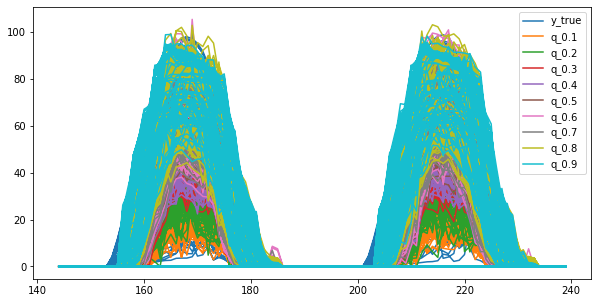

In [132]:
final_result2 = final_result2[(final_result2['day']==7) | (final_result2['day']==8)]
final_result2.drop(['id','day','hour'],axis =1).plot(figsize = (10,5))

In [133]:
# save result file
final_result2 = final_result2.drop(['y_true', 'day', 'hour'], axis=1)
#final_result2.to_csv('submission_4.csv', index = False)

In [134]:
final_result2

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
144,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
235,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### feature importance 확인

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

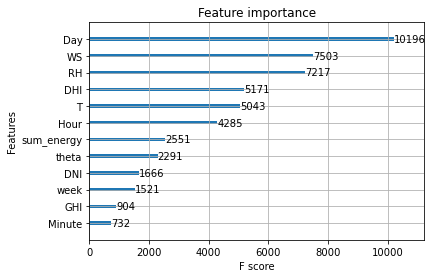

In [135]:
file_name = 'model_0.4.pkl' 
model = joblib.load(file_name)

from xgboost import plot_importance
plot_importance(model, )

In [136]:
df2.corr()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET2,week,sum_energy,theta,GHI
Day,1.000000,0.000000,0.000000,-0.087184,0.145994,-0.187523,-0.151617,0.511484,-0.037857,NaN,0.092051,0.000000,-0.003930
Hour,0.000000,1.000000,0.000000,0.080799,-0.087591,-0.279279,-0.192234,0.271047,-0.026410,NaN,-0.044935,0.118901,-0.042683
Minute,0.000000,0.000000,1.000000,-0.007152,0.013299,0.003202,-0.003356,0.004269,0.008404,NaN,0.008670,0.000000,0.009835
DHI,-0.087184,0.080799,-0.007152,1.000000,0.250892,0.500239,-0.731575,0.594697,0.715623,NaN,0.573551,0.898879,0.362419
DNI,0.145994,-0.087591,0.013299,0.250892,1.000000,0.284516,-0.653926,0.581607,0.598277,NaN,0.936868,0.419506,0.202865
WS,-0.187523,-0.279279,0.003202,0.500239,0.284516,1.000000,-0.331033,0.140447,0.504076,NaN,0.421473,0.402665,0.344152
RH,-0.151617,-0.192234,-0.003356,-0.731575,-0.653926,-0.331033,1.000000,-0.894211,-0.821178,NaN,-0.817648,-0.849101,-0.282296
T,0.511484,0.271047,0.004269,0.594697,0.581607,0.140447,-0.894211,1.000000,0.664942,NaN,0.707004,0.746324,0.214131
TARGET2,-0.037857,-0.026410,0.008404,0.715623,0.598277,0.504076,-0.821178,0.664942,1.000000,NaN,0.764794,0.775559,0.322573
week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
